# Predicting performances for the Arithmetic dataset with a hierarchical measurement layout

Here, I build a measurement layout with hierarchical structure for the Arithmetic dataset for the measurement layout tutorial.  

From 1 to 5 digits and 4 possible operations (addition, subtraction, multiplication, division), there are 20 possible combinations. These are then 2 deterministic features, that are not very advanced however.

In [1]:
import warnings

# Filter warnings for the specific library you want to suppress
warnings.filterwarnings("ignore", category=FutureWarning, module="sklearn")
warnings.filterwarnings("ignore", category=FutureWarning, module="seaborn")

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import pymc as pm
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from xgboost import XGBClassifier

%load_ext autoreload
%autoreload 2

In [2]:
print(f"Running on PyMC v{pm.__version__}")

Running on PyMC v5.9.2


In [3]:
!python --version

Python 3.11.6


## Define utility functions

In [4]:
# logistic function with standard parameters
def logistic(x, x0=0, k=1):
    """
    Generalized logistic function allowing to specify the center of the curve and the steepness.
    See at https://en.wikipedia.org/wiki/Generalised_logistic_function

    One can also include other parameters:
    :math:`y(x) = \frac{K}{(1+e^{-Bx})^{1/\nu}}`
    where K can be set so that the maximum value is 1 even if the domain of the parameter is bounded and
    $\nu$ dictates close to which asymptot maximum growth occurs. For now we keep them both fixed at 1

    :param x: The x value
    :param x0: The function is centred on x0 (where the probability is 0.5)
    :param k: The slope (steepness) is k
    :return:

    """
    # notice that you cannot use scipy advanced math here as this will be used by pymc. This may not be the most
    # efficient implementation
    return 1 / (1 + np.exp(-k * (x - x0)))


# the margin is just the subtraction, assuming ability and demand are *in the same scale*
def margin(ability, demand):
    return ability - demand


def brierDecomp(preds, outs):
    brier = 1 / len(preds) * sum((preds - outs) ** 2)
    ## bin predictions
    bins = np.linspace(0, 1, 11)
    binCenters = (bins[:-1] + bins[1:]) / 2
    binPredInds = np.digitize(preds, binCenters)
    binnedPreds = bins[binPredInds]

    binTrueFreqs = np.zeros(10)
    binPredFreqs = np.zeros(10)
    binCounts = np.zeros(10)

    for i in range(10):
        idx = (preds >= bins[i]) & (preds < bins[i + 1])

        binTrueFreqs[i] = np.sum(outs[idx]) / np.sum(idx) if np.sum(idx) > 0 else 0
        # print(np.sum(outs[idx]), np.sum(idx), binTrueFreqs[i])
        binPredFreqs[i] = np.mean(preds[idx]) if np.sum(idx) > 0 else 0
        binCounts[i] = np.sum(idx)

    calibration = np.sum(binCounts * (binTrueFreqs - binPredFreqs) ** 2) / np.sum(binCounts) if np.sum(
        binCounts) > 0 else 0
    refinement = np.sum(binCounts * (binTrueFreqs * (1 - binTrueFreqs))) / np.sum(binCounts) if np.sum(
        binCounts) > 0 else 0
    # Compute refinement component
    # refinement = brier - calibration
    return brier, calibration, refinement


# define generic function to evaluate a predictive method (such as LogisticRegression)
def evaluate_predictive_method(df_train, df_test, features_cols, response_col, predictive_method=LogisticRegression,
                               return_trained_method=False, compute_accuracy=False, trained_method=None, **kwargs):
    if len(features_cols) == 1 and type(df_train[features_cols[0]].iloc[0]) == np.ndarray:
        # if the features are already a numpy array, then don't convert to numpy array
        features_train = np.array(list(df_train[features_cols[0]].values))
        features_test = np.array(list(df_test[features_cols[0]].values))
    else:
        # traditional one
        features_train = df_train[features_cols].to_numpy()
        features_test = df_test[features_cols].to_numpy()

    if response_col in features_cols:
        raise ValueError("response_col must not be in features_cols")

    if trained_method is not None:
        method_instance = trained_method
    else:
        # fit logistic regression using training features and the agent col as response
        method_instance = predictive_method(**kwargs)
        method_instance.fit(features_train, df_train[response_col])

    # evaluate on the test set
    y_pred = method_instance.predict_proba(features_test)[:, 1]

    BrierScore, Calibration, Refinement = brierDecomp(y_pred, df_test[response_col])
    # compute the ROC AUC using sklearn
    if not (sum(df_test[response_col]) == 0 or sum(df_test[response_col]) == len(df_test)):
        roc_auc = roc_auc_score(df_test[response_col], y_pred)
    else:
        roc_auc = np.nan

    if compute_accuracy:
        # compute accuracy by thresholding at 0.5
        y_pred_binary = y_pred > 0.5
        accuracy = np.mean(y_pred_binary == df_test[response_col])

    return_list = [BrierScore, Calibration, Refinement, roc_auc]
    if compute_accuracy:
        return_list.append(accuracy)
    if return_trained_method:
        return_list.append(method_instance)
    return return_list


# Load real results

In [5]:
llms = ["text-ada-001", "text-babbage-001", "text-curie-001", "text-davinci-001", "text-davinci-002",
        "text-davinci-003", "gpt-3.5-turbo-1106", "gpt-4-1106-preview", ]
# 5 digits and 4 operations
subtasks = [[f"{n}_digit_{operation}" for n in range(1, 6)] for operation in
            ["addition", "subtraction", "multiplication", "division"]]
# create a single list
subtasks = [item for sublist in subtasks for item in sublist]

In [6]:
results_dict = {}
for llm in llms:
    results_dict[llm] = {}
    for subtask in subtasks:
        # print(subtask)
        # check if this file exists: 
        # print(os.path.isfile(f"../results/arithmetic_{subtask}/{llm}.jsonl"))
        results_dict[llm][subtask] = pd.read_json(f"../data/arithmetic_results/arithmetic_{subtask}/{llm}.jsonl", lines=True)

In [7]:
def check_answer_correct(row):
    # strip spaces, new lines and "."
    expected = row["match"]["expected"].strip().lower().replace("\n", "").replace(".", "").replace("\"", "")
    sampled = row["match"]["sampled"].strip().lower().replace("\n", "").replace(".", "").replace("\"", "")

    if expected in sampled:
        return 1
    else:
        return 0


def reformat_results_df(results_df):
    # discard all things where run_id is nan
    results_df = results_df[~results_df["run_id"].isna()]
    # drop the "spec", "final_report" and "created_by" columns
    results_df = results_df.drop(columns=["spec", "final_report", "created_by"])

    # There are two events for each "sample_id" (one for the sampling and one for the evaluation, called "match").
    # Use pivot to put them in a proper format
    # results dataframe in a different format: one row per sample_id, where I will store the "data" entry for the "sampling" and "metrics" events
    results_df = results_df.pivot(index="sample_id", columns="type", values="data")
    # define "Success"  
    # results_df["Success"] = results_df.apply(lambda x: 1 if x["match"]["correct"] else 0, axis=1)
    # IMPORTANT I redefine here success as the naive match does not strip nor lower the strings
    results_df["Success"] = results_df.apply(check_answer_correct, axis=1)
    # now extract the original prompt; this depends on whether the prompt is a list or not
    # the way the prompt is stored is different for chat and completion models
    if isinstance(results_df.iloc[0]["sampling"]["prompt"], list):
        results_df["prompt"] = results_df.apply(lambda x: x["sampling"]["prompt"][1]["content"], axis=1)
        # print("prompt is a list")
    else:
        results_df["prompt"] = results_df.apply(lambda x: x["sampling"]["prompt"], axis=1)
        results_df["prompt"] = results_df["prompt"].apply(lambda x: x.split("\nUser: ")[1].split("\nAssistant:")[0])
        # print("prompt is a string")
    return results_df

In [8]:
# do split for all llms
for llm in llms:
    for subtask in subtasks:
        results_df = reformat_results_df(results_dict[llm][subtask])
        results_df["n_digits"] = int(subtask.split("_")[0])
        results_df["operation"] = subtask.split("_")[2]
        results_dict[llm][subtask] = results_df

In [9]:
# concatenate all dfs for each llm
results_dict_all_subtasks = {}
for llm in llms:
    results_dict_all_subtasks[llm] = pd.concat([results_dict[llm][subtask] for subtask in subtasks])

Create a dataframe with the success rate for each model, operation and n_digits:

In [10]:
success_rate_df = pd.DataFrame()
for llm in llms:
    for subtask in subtasks:
        success_rate_df = pd.concat([success_rate_df, pd.DataFrame(
            {"llm": llm, "n_digits": int(subtask.split("_")[0]), "operation": subtask.split("_")[2],
             "success_rate": results_dict[llm][subtask]["Success"].sum() / len(results_dict[llm][subtask])},
            index=[0])])

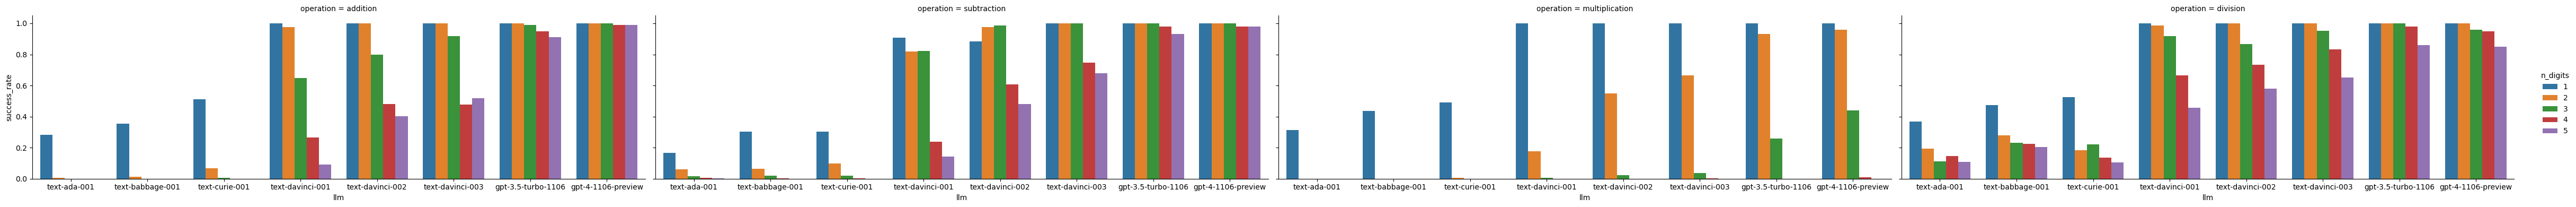

In [11]:
sns.catplot(x="llm", y="success_rate", hue="n_digits", col="operation", data=success_rate_df, kind="bar", height=4,
            aspect=3)

Create dummy variables for the operation type

In [12]:
for llm in llms:
    results_dict_all_subtasks[llm]["is_addition"] = 0
    results_dict_all_subtasks[llm]["is_subtraction"] = 0
    results_dict_all_subtasks[llm]["is_multiplication"] = 0
    results_dict_all_subtasks[llm]["is_division"] = 0
    results_dict_all_subtasks[llm].loc[results_dict_all_subtasks[llm]["operation"] == "addition", "is_addition"] = 1
    results_dict_all_subtasks[llm].loc[
        results_dict_all_subtasks[llm]["operation"] == "subtraction", "is_subtraction"] = 1
    results_dict_all_subtasks[llm].loc[
        results_dict_all_subtasks[llm]["operation"] == "multiplication", "is_multiplication"] = 1
    results_dict_all_subtasks[llm].loc[results_dict_all_subtasks[llm]["operation"] == "division", "is_division"] = 1

Split the data into in and out of distribution; use a subset of the in-distribution data for training the assessor and then define two test sets, one with in distribution data and one with out of distribution data. I also define an "extended" training distribution which includes some out of distribution data (but has the same number of samples as the original training set).

In [13]:
train_results_dict = {}
test_results_dict = {}
for llm in llms:
    df = results_dict_all_subtasks[llm]
    # reset index
    df = df.reset_index(drop=True)
    df_train = df.sample(frac=0.8, random_state=0)
    df_test = df.drop(df_train.index)

    train_results_dict[llm] = df_train
    test_results_dict[llm] = df_test

    print(llm, len(df_train), len(df_test))

text-ada-001 11954 2989
text-babbage-001 11954 2989
text-curie-001 11954 2989
text-davinci-001 11954 2989
text-davinci-002 11954 2989
text-davinci-003 11954 2989
gpt-3.5-turbo-1106 1526 381
gpt-4-1106-preview 1526 381


A bit more than 25% are 0's in the test set.

# Predictive assessors

In [14]:
list_features = ['n_digits', "is_addition", "is_subtraction", "is_multiplication"]

predictive_methods_df = pd.DataFrame()
for predictive_method in [LogisticRegression, XGBClassifier]:
    for llm in llms:
        print(llm)
        df_train = train_results_dict[llm]  # default training set
        df_test = test_results_dict[llm]  # default test set
        # in distribution performance
        BrierScore, Calibration, Refinement, roc_auc, trained_method = evaluate_predictive_method(df_train, df_test,
                                                                                                  list_features,
                                                                                                  "Success",
                                                                                                  predictive_method=predictive_method,
                                                                                                  return_trained_method=True)
        predictive_methods_df = pd.concat([predictive_methods_df, pd.DataFrame(
            {"predictive_method": predictive_method.__name__, "llm": llm, "BrierScore": BrierScore,
             "Calibration": Calibration, "Refinement": Refinement, "AUROC": roc_auc, "trained_method": trained_method},
            index=[0])])

        for baseline in ["always_1", "always_0", "average_success_on_train"]:
            if baseline == "always_1":
                predictions = np.ones(len(df_test))
            elif baseline == "always_0":
                predictions = np.zeros(len(df_test))
            elif baseline == "average_success_on_train":
                predictions = np.ones(len(df_test)) * df_train["Success"].mean()
            else:
                raise ValueError("baseline not recognized")

            BrierScore, Calibration, Refinement = brierDecomp(predictions, df_test["Success"])
            roc_auc = roc_auc_score(df_test["Success"], predictions)
            predictive_methods_df = pd.concat([predictive_methods_df, pd.DataFrame(
                {"predictive_method": baseline, "llm": llm, "BrierScore": BrierScore, "Calibration": Calibration,
                 "Refinement": Refinement, "AUROC": roc_auc, }, index=[0])])


text-ada-001
text-babbage-001
text-curie-001
text-davinci-001
text-davinci-002
text-davinci-003
gpt-3.5-turbo-1106
gpt-4-1106-preview
text-ada-001


/home/lorenzo/miniconda3/envs/recog-LLM_capabilities_conda/lib/python3.11/site-packages/xgboost/data.py:427: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


text-babbage-001


/home/lorenzo/miniconda3/envs/recog-LLM_capabilities_conda/lib/python3.11/site-packages/xgboost/data.py:427: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


text-curie-001


/home/lorenzo/miniconda3/envs/recog-LLM_capabilities_conda/lib/python3.11/site-packages/xgboost/data.py:427: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


text-davinci-001


/home/lorenzo/miniconda3/envs/recog-LLM_capabilities_conda/lib/python3.11/site-packages/xgboost/data.py:427: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


text-davinci-002


/home/lorenzo/miniconda3/envs/recog-LLM_capabilities_conda/lib/python3.11/site-packages/xgboost/data.py:427: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


text-davinci-003


/home/lorenzo/miniconda3/envs/recog-LLM_capabilities_conda/lib/python3.11/site-packages/xgboost/data.py:427: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


gpt-3.5-turbo-1106


/home/lorenzo/miniconda3/envs/recog-LLM_capabilities_conda/lib/python3.11/site-packages/xgboost/data.py:427: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


gpt-4-1106-preview


/home/lorenzo/miniconda3/envs/recog-LLM_capabilities_conda/lib/python3.11/site-packages/xgboost/data.py:427: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


In [15]:
predictive_methods_df[['predictive_method', 'llm', 'AUROC', 'BrierScore', 'Calibration', 'Refinement']].sort_values(
    by="BrierScore")

,predictive_method,llm,AUROC,BrierScore,Calibration,Refinement
0,XGBClassifier,gpt-3.5-turbo-1106,0.978919,0.025713,0.003978,0.022917
0,LogisticRegression,gpt-3.5-turbo-1106,0.975170,0.029273,0.007446,0.022041
0,LogisticRegression,gpt-4-1106-preview,0.986587,0.029532,0.000414,0.029133
0,XGBClassifier,gpt-4-1106-preview,0.974819,0.030780,0.000947,0.029639
0,XGBClassifier,text-ada-001,0.889085,0.032555,0.000145,0.033845
...,...,...,...,...,...,...
0,always_1,text-babbage-001,0.500000,0.941787,0.000000,0.000000
0,always_1,text-curie-001,0.500000,0.951823,0.000000,0.000000
0,always_1,text-curie-001,0.500000,0.951823,0.000000,0.000000
0,always_1,text-ada-001,0.500000,0.962195,0.000000,0.000000


Add  baselines:

Text(0.5, 1.0, 'In distribution')

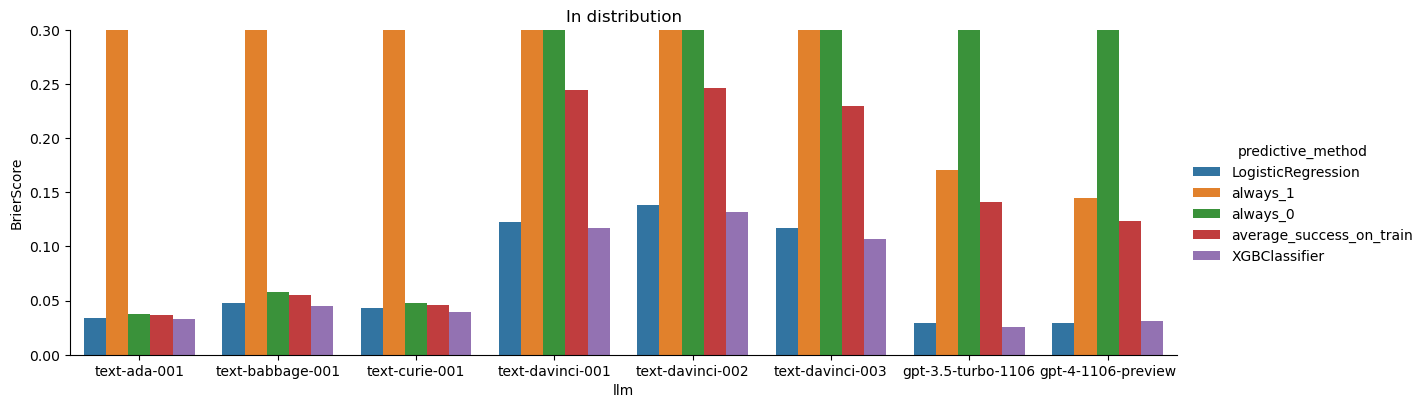

In [16]:
sns.catplot(x="llm", y="BrierScore", hue="predictive_method", data=predictive_methods_df, kind="bar", height=4,
            aspect=3)
# set the ylim
plt.ylim(0, 0.3)
plt.title("In distribution")

# Build a measurement layout

In [17]:
def setup_arithmetic_hierarchical_model(data, noise=False, slopes=False):
    m = pm.Model()
    with m:
        ### Task Features (demands) as Deterministic
        n_digits_demands = pm.MutableData("n_digits", data["n_digits"].values)
        is_addition = pm.MutableData("is_addition", data["is_addition"].values)
        is_subtraction = pm.MutableData("is_subtraction", data["is_subtraction"].values)
        is_multiplication = pm.MutableData("is_multiplication", data["is_multiplication"].values)
        is_division = pm.MutableData("is_division", data["is_division"].values)

        ### prior on the general n_digits capability
        n_digits_capability = pm.Exponential("n_digits_capability", lam=1)
        ### Define a capability for each n_digit operation individually, with mean being the general n_digits capability
        n_digits_addition_capability = pm.Exponential("n_digits_addition_capability", lam=1 / n_digits_capability)
        n_digits_subtraction_capability = pm.Exponential("n_digits_subtraction_capability", lam=1 / n_digits_capability)
        n_digits_multiplication_capability = pm.Exponential("n_digits_multiplication_capability",
                                                            lam=1 / n_digits_capability)
        n_digits_division_capability = pm.Exponential("n_digits_division_capability", lam=1 / n_digits_capability)

        if noise:
            noise_level = pm.Uniform("noise_level", 0, 1)
            average_success = data["Success"].mean()  # this is using data twice

        if slopes:
            # add slopes parameters for all of the three capabilities. We want a distribution with positive support only and peaked at 1:
            # use a gamma distribution:
            alpha = beta = 15  # these lead to a mean of 1 and standard deviation of 0.26 for the prior
            n_digits_slope = pm.Gamma("n_digits_slope", alpha, beta)

        ###  margin between capability and demands
        n_digits_addition_margin = pm.Deterministic("n_digits_addition_margin",
                                                    logistic(margin(n_digits_addition_capability, n_digits_demands),
                                                             k=n_digits_slope if slopes else 1))
        n_digits_subtraction_margin = pm.Deterministic("n_digits_subtraction_margin", logistic(
            margin(n_digits_subtraction_capability, n_digits_demands), k=n_digits_slope if slopes else 1))
        n_digits_multiplication_margin = pm.Deterministic("n_digits_multiplication_margin", logistic(
            margin(n_digits_multiplication_capability, n_digits_demands), k=n_digits_slope if slopes else 1))
        n_digits_division_margin = pm.Deterministic("n_digits_division_margin",
                                                    logistic(margin(n_digits_division_capability, n_digits_demands),
                                                             k=n_digits_slope if slopes else 1))

        p_before_noise = pm.Deterministic("p_before_noise",
                                          n_digits_addition_margin * is_addition + n_digits_subtraction_margin * is_subtraction + n_digits_multiplication_margin * is_multiplication + n_digits_division_margin * is_division)

        if noise:
            integrated_p = pm.Deterministic("finalP",
                                            (1 - noise_level) * p_before_noise + noise_level * average_success)
        else:
            integrated_p = pm.Deterministic("finalP", p_before_noise)

        TaskPerformance = pm.Bernoulli("TaskPerformance", integrated_p, observed=data["Success"].values)
    return m

In [18]:
train_df = train_results_dict["gpt-3.5-turbo-1106"]

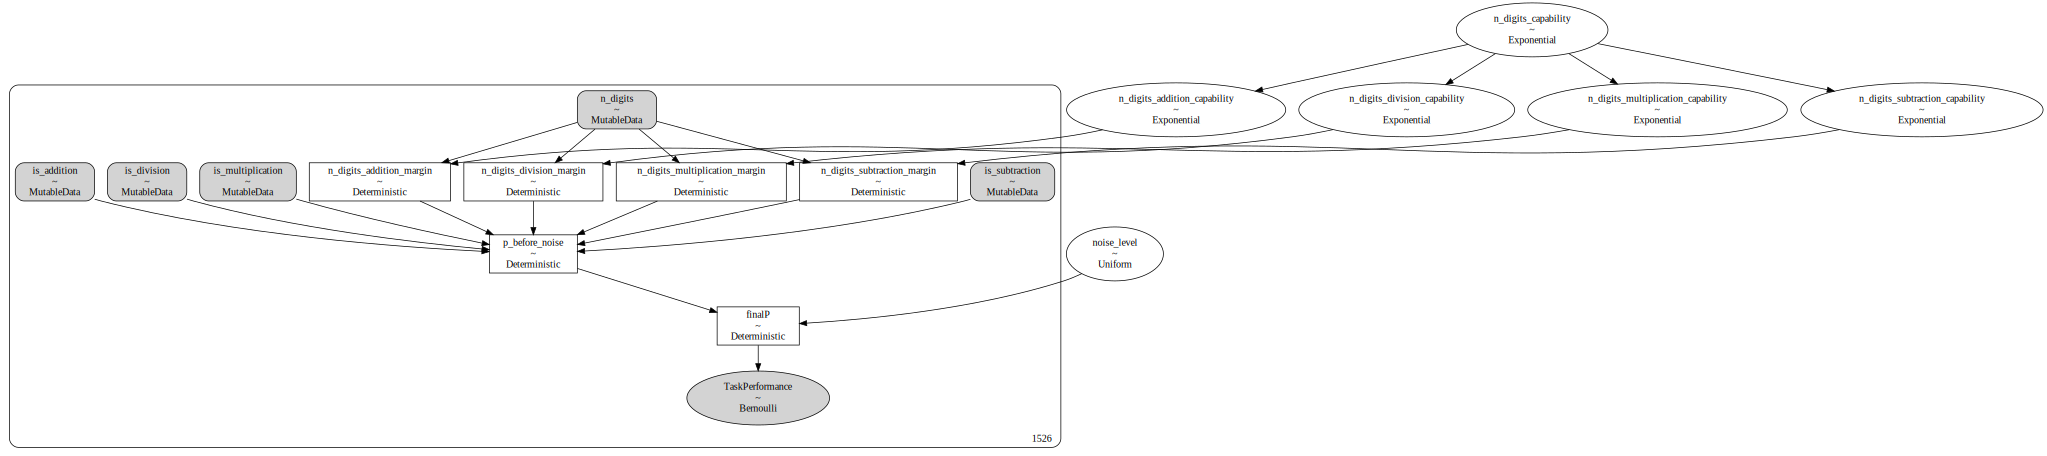

In [19]:
# instantiate the model and plot the diagram
model = setup_arithmetic_hierarchical_model(train_df, noise=True, slopes=False)

pm.model_to_graphviz(model)

## Do inference with the model  

In [ ]:
list_variables = ["n_digits_capability", "n_digits_addition_capability", "n_digits_subtraction_capability",
                  "n_digits_multiplication_capability", "n_digits_division_capability", "noise_level"]

n_samples = 2000
tune = 1000
RUN = True

llms_for_mcmc = llms

if RUN:
    trace_dict = {}
    for llm in llms_for_mcmc:
        print(llm)
        train_df = train_results_dict[llm]
        model = setup_arithmetic_hierarchical_model(train_df, noise=True, slopes=False)

        # inference
        with model:
            trace = pm.sample(n_samples, tune=tune)
        trace_dict[llm] = trace['posterior'][list_variables]

text-ada-001


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [n_digits_capability, n_digits_addition_capability, n_digits_subtraction_capability, n_digits_multiplication_capability, n_digits_division_capability, noise_level]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 122 seconds.


text-babbage-001


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [n_digits_capability, n_digits_addition_capability, n_digits_subtraction_capability, n_digits_multiplication_capability, n_digits_division_capability, noise_level]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 145 seconds.


Save the traces to file

In [1]:
if RUN:
    with open("results/arithmetic_traces_hierarhical.pkl", "wb") as f:
        pickle.dump(trace_dict, f)

NameError: name 'RUN' is not defined

Reload the traces from file:

In [ ]:
# load:
with open("results/arithmetic_traces_hierarhical.pkl", "rb") as f:
    trace_dict = pickle.load(f)

In [ ]:
type(trace_dict)

In [ ]:
for llm in llms_for_mcmc:
    print(llm)
    az.plot_trace(data=trace_dict[llm], var_names=list_variables)

Boxplot of the capabilities of all LLMs:

In [ ]:
list_variables = ["n_digits_capability", "n_digits_addition_capability", "n_digits_subtraction_capability",
                  "n_digits_multiplication_capability", "n_digits_division_capability", "noise_level"]

fig, axes = plt.subplots(len(list_variables), 1, figsize=(8, 3 * len(list_variables)), sharex="col")
if len(list_variables) == 1:
    axes = [axes]
for ax, capability in zip(axes, list_variables):
    ax.boxplot([trace_dict[llm][capability].to_numpy().flatten() for llm in llms_for_mcmc])
    ax.set_title(capability)
ax.set_xticks(np.arange(len(llms_for_mcmc)) + 1, llms_for_mcmc, rotation=90)
plt.show()

### Evaluate the predictive performance of this model

In [ ]:
def predict(m, trace, df_test):
    with m:
        predictions = pm.sample_posterior_predictive(trace, var_names=["finalP"], return_inferencedata=False,
                                                     predictions=True, extend_inferencedata=False, random_seed=0)
        # the above generates one predictive sample for each posterior sample
        predictionChainRuns = predictions["finalP"][:, :, 0:len(df_test)]
        predictionsInstance = np.mean(predictionChainRuns, (0, 1))

        return predictionsInstance

In [ ]:
for llm in llms_for_mcmc:
    print(llm)
    df_train = train_results_dict[llm]
    df_test = test_results_dict[llm]

    trace = trace_dict[llm]

    # re-instantiate the model with the test data
    bayesian_model = setup_arithmetic_hierarchical_model(df_test, noise=True, slopes=False)

    predictions = predict(bayesian_model, trace, df_test)
    BrierScore, Calibration, Refinement = brierDecomp(predictions, df_test["Success"])
    roc_auc = roc_auc_score(df_test["Success"], predictions)
    predictive_methods_df = pd.concat([predictive_methods_df, pd.DataFrame(
        {"predictive_method": "bayesian_model", "llm": llm, "BrierScore": BrierScore, "Calibration": Calibration,
         "Refinement": Refinement, "AUROC": roc_auc, }, index=[0])])


In [ ]:
sns.catplot(x="llm", y="BrierScore", hue="predictive_method", data=predictive_methods_df, kind="bar", height=4,
            aspect=3)
# set the ylim
plt.ylim(0, 0.3)
plt.title("In distribution")